
# **Data Visualization & Customer Segmentation using K-Means**

## **Post Script 2022**

This was my first kaggle notebook several years ago. How I have written this code is **not** optimal. I would wager the code can almost be cut in half. I have left this notebook active as the visualizations are cool... but the code is not!

## **Context**

We have been tasked with identifying customer segments and delivering insight about our data in general, and about these clusters.

This is a real-world technique that can have a direct effect on how businesses behave towards their customers.

## **References**

This is **my first Kaggle notebook**, and I learned a lot whilst making it.

**Many of the visuals were originally created by Subin An**, please check out his profile for more Data Visualisation:

https://www.kaggle.com/subinium

**Another great resource** is:

https://www.python-graph-gallery.com/


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


## **Read Data**

In [2]:
# Quick overview of the data
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# **Let's visualize**

What is the general make-up of our customer base?

In [3]:
# Age bin / range
bins = [18, 22, 50, 70]
labels = ['Young', 'Adult', 'Senior']
df['Age Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

def plot_ratio(df):
    # For viz: Ratio of Males & Females

    x=df.groupby(['Gender'])['Gender'].count()
    y=len(df)
    r=((x/y)).round(2)

    mf_ratio = pd.DataFrame(r).T
    
    fig, ax = plt.subplots(1,1,figsize=(12, 3), dpi=75)

    ax.barh(mf_ratio.index, mf_ratio['Male'], 
            color='#244747', alpha=0.7, label='Male')
    ax.barh(mf_ratio.index, mf_ratio['Female'], left=mf_ratio['Male'], 
            color='#91b8bd', alpha=0.7, label='Female')

    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # male percentage
    for i in mf_ratio.index:
        ax.annotate(f"{int(mf_ratio['Male'][i]*100)}%", 
                       xy=(mf_ratio['Male'][i]/2, i),
                       va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                       color='white')

        ax.annotate("Male", 
                       xy=(mf_ratio['Male'][i]/2, -0.25),
                       va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='white')


    for i in mf_ratio.index:
        ax.annotate(f"{int(mf_ratio['Female'][i]*100)}%", 
                       xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, i),
                       va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                       color='#244747')
        ax.annotate("Female", 
                       xy=(mf_ratio['Male'][i]+mf_ratio['Female'][i]/2, -0.25),
                       va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='#244747')


    # Title & Subtitle
    fig.text(0.125,1.03,'Male & Female distribution', fontfamily='serif',fontsize=15, fontweight='bold')
    fig.text(0.125,0.92,'We see a fairly even split, but with slightly more females.',fontfamily='serif',fontsize=12)  

    for s in ['top', 'left', 'right', 'bottom']:
        ax.spines[s].set_visible(False)

    # Removing legend due to labelled plot
    ax.legend().set_visible(False)
    plt.show()


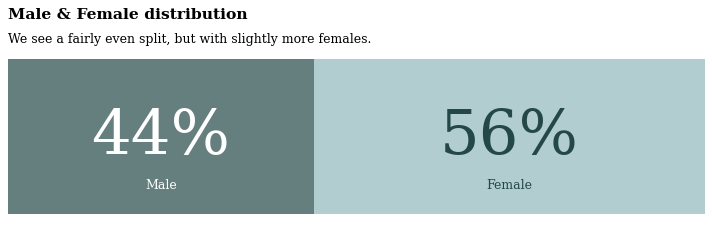

In [4]:
plot_ratio(df)

So we have a fairly even split. 

Does the split vary by age?

All this information will be important for interpreting our clusters later on.

Always ask then question "so what?" - If we have, for example, more females as customers, how might we advertise differently?

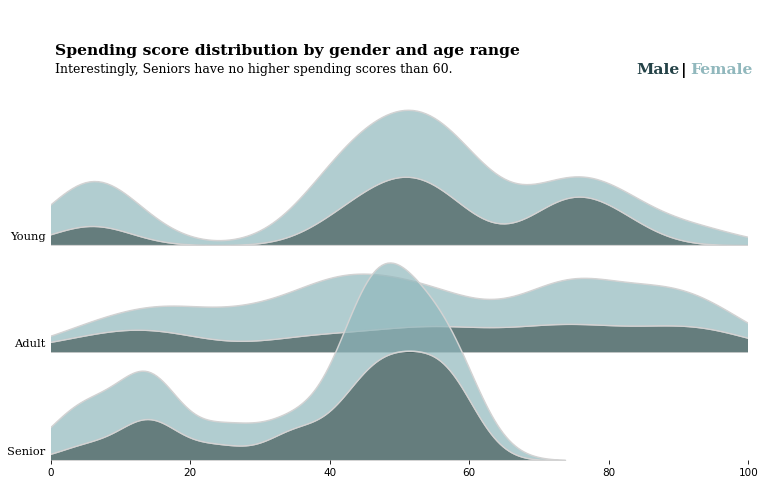

In [5]:
fig = plt.figure(figsize=(12, 8), dpi=75)
gs = fig.add_gridspec(3,1)
gs.update(hspace= -0.55)

axes = list()
colors = ["#004c70", "#990000",'#990000']

for idx, cls, c in zip(range(4), df['Age Range'].unique(), colors):
    axes.append(fig.add_subplot(gs[idx, 0]))
    
    # you can also draw density plot with matplotlib + scipy.
    sns.kdeplot(x='Spending Score (1-100)', data=df[df['Age Range']==cls], 
                fill=True, ax=axes[idx], cut=3, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray',multiple="stack", palette=['#91b8bd','#244747'], alpha=0.7,hue='Gender') 
               
    axes[idx].set_ylim(0, 0.04)
    axes[idx].set_xlim(0, 100)
    
    axes[idx].set_yticks([])
    if idx != 2 : axes[idx].set_xticks([])
    axes[idx].set_ylabel('')
    axes[idx].set_xlabel('')
    
    spines = ["top","right","left","bottom"]
    for s in spines:
        axes[idx].spines[s].set_visible(False)
        
    axes[idx].patch.set_alpha(0)
    axes[idx].text(-0.2,0.001,f'{cls} ',fontweight="light", fontfamily='serif', fontsize=11,ha="right")
    if idx != 4 : axes[idx].get_legend().remove() 
    

fig.text(0.13,0.8,"Spending score distribution by gender and age range", fontweight="bold", fontfamily='serif', fontsize=15)
fig.text(0.13,0.77,'Interestingly, Seniors have no higher spending scores than 60.',fontfamily='serif',fontsize=12)

fig.text(0.776,0.77,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.825,0.77,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.835,0.77,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

plt.show()   

Okay, so we notice several prominent areas in our dataset.

We can explore age a bit deeper...

In [6]:
# Some quick feature engineering, just in case
df['Gender 1/0'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

def age_band(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

df['age_band'] = df['Age'].apply(age_band)


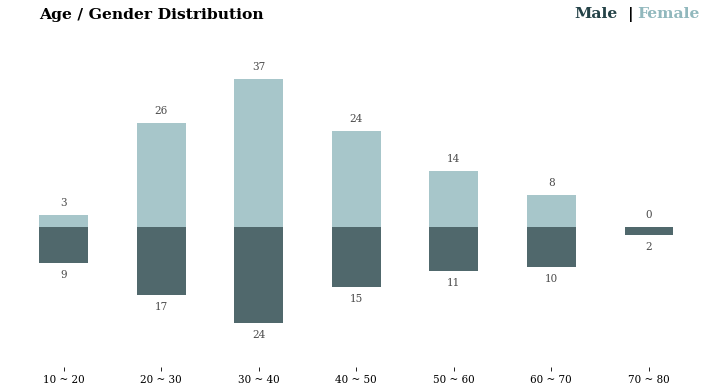

In [7]:
mf = df.groupby('Gender')['age_band'].value_counts().unstack().sort_index().fillna(0).astype(int)


female = mf.loc['Female']
male = -mf.loc['Male']

fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=75)
ax.bar(male.index, male, width=0.5, color='#244247', alpha=0.8, label='Male')
ax.bar(female.index, female, width=0.5, color='#91b8bd', alpha=0.8, label='Female')
ax.set_ylim(-35, 50)

# Annotations
for i in female.index:
    ax.annotate(f"{female[i]}", 
                   xy=(i, female[i] + 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in male.index:
    ax.annotate(f"{-male[i]}", 
                   xy=(i, male[i] - 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 0.9, 'Age / Gender Distribution', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(0.755,0.9,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.815,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.9,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

plt.show()

Our most prominent age range is between 30 and 40 for both males and females. 

Though, we have significant numbers from 20 through to 50.

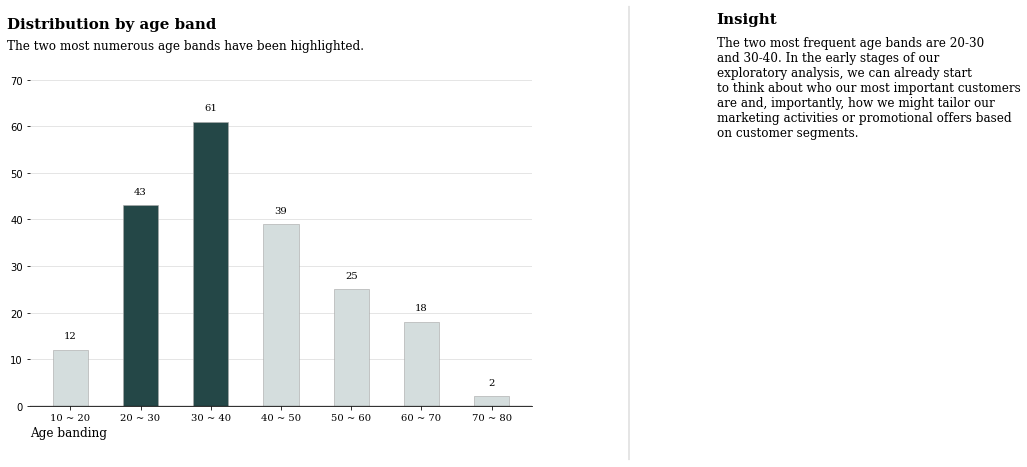

In [8]:
# Order for plotting categorical vars
ab_order = ['10 ~ 20', '20 ~ 30', '30 ~ 40','40 ~ 50','50 ~ 60' ,'60 ~ 70', '70 ~ 80']

data = df['age_band'].value_counts()[ab_order]

color_map = ['#d4dddd' for _ in range(9)]
color_map[2] = color_map[1] = '#244747' 

fig, ax = plt.subplots(1,1, figsize=(9, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)


#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 3), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    


ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title

fig.text(0.09, 1, 'Distribution by age band', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The two most numerous age bands have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.185, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.185, 0.715, '''
The two most frequent age bands are 20-30 
and 30-40. In the early stages of our 
exploratory analysis, we can already start
to think about who our most important customers
are and, importantly, how we might tailor our
marketing activities or promotional offers based
on customer segments.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 75, 10) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

plt.xlabel("Age banding", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)

    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

import matplotlib.lines as lines
l1 = lines.Line2D([1.05, 1.05], [0, 1.05], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


plt.show()

# Preparing to cluster: What about the distribution of our data?

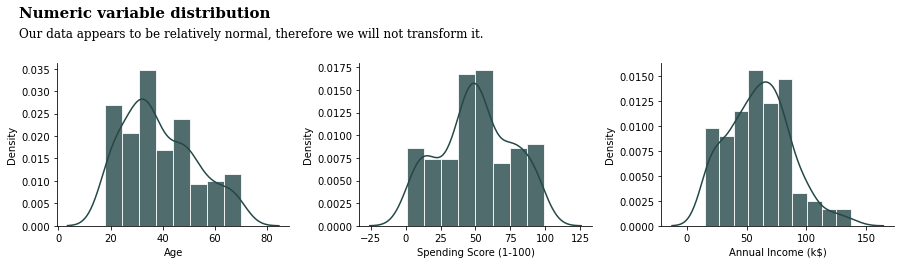

In [9]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15, 3))


fig.text(0.09, 1.09, 'Numeric variable distribution', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 1, 'Our data appears to be relatively normal, therefore we will not transform it.', fontsize=12, fontweight='light', fontfamily='serif')


ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.distplot(df["Age"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.distplot(df["Spending Score (1-100)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.distplot(df["Annual Income (k$)"],color='#244747',hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))

sns.despine()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None) # useful for adjusting space between subplots


The data isn't too extreme so I won't transform it. 


## **Let's now look at how our numeric variables are related to each other**

statistical plots can help us to spot relationships between variables in our datset.

In this case, we even spot potential clusters...

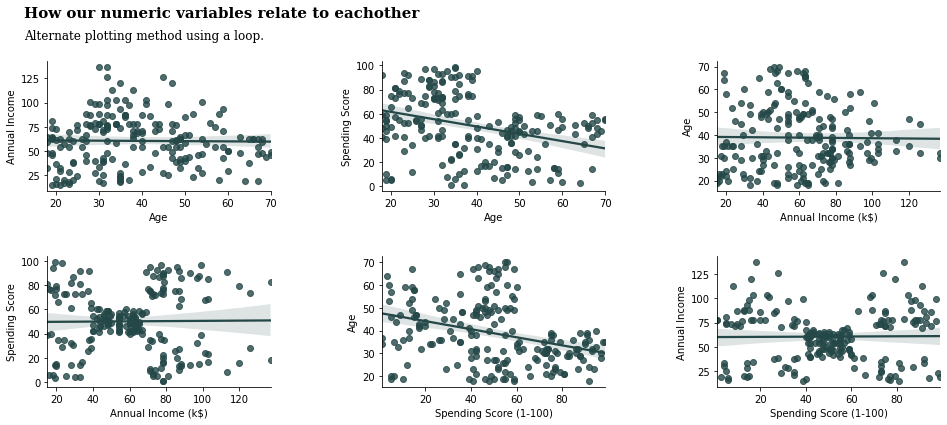

In [10]:
fig = plt.figure(figsize=(16, 6))
# Title and sub-title
fig.text(0.105, .98, 'How our numeric variables relate to eachother', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.105, .93, 'Alternate plotting method using a loop.', fontsize=12, fontweight='light', fontfamily='serif')

n = 0 

for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        if x==y: continue

        n += 1
        plt.subplot(2 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = df,color='#244747')
        sns.despine()
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None) # useful for adjusting space between subplot

plt.show()


## **There's an interesting plot that I would like to zoom in on**

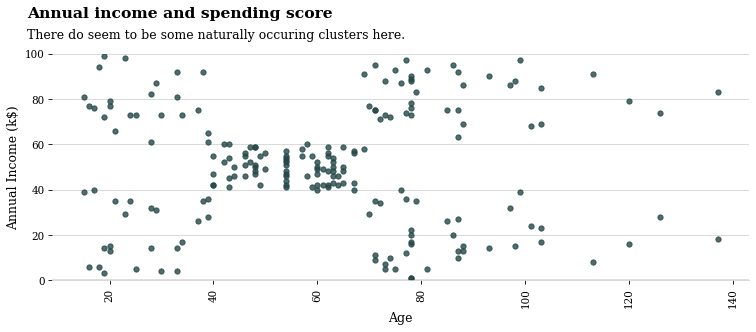

In [11]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=75)

# Title & Subtitle
fig.text(0.097,1,'Annual income and spending score', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.097,0.93,'There do seem to be some naturally occuring clusters here.',fontfamily='serif',fontsize=12)

# Ax spines
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.spines['bottom'].set_color('lightgray')

# Grid
ax.set_axisbelow(True)
ax.yaxis.grid(color='lightgray', linestyle='-')

# Plot

plt.scatter(x = 'Annual Income (k$)' , y = 'Spending Score (1-100)' , data = df ,color='#244747',s = 25 , alpha = 0.8 )


# Tick control
plt.yticks(fontsize=10, fontfamily='serif',fontweight='light')
#ax.yaxis.set_ticks(np.arange(0,140,10))

plt.xticks(fontsize=10, fontfamily='serif',fontweight='light',rotation=90)

# Label control
ax.set_ylabel('Annual Income (k$)',fontfamily='serif',fontsize=12)
ax.set_xlabel('Age',fontfamily='serif',fontsize=12)

ax.set_ylim(0, 100)
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

plt.show()

## **Clustering**

In [12]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Spending Score (1-100)", "Annual Income (k$)", "Age"]
cluster_data = df.loc[:,selected_cols]

In [13]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

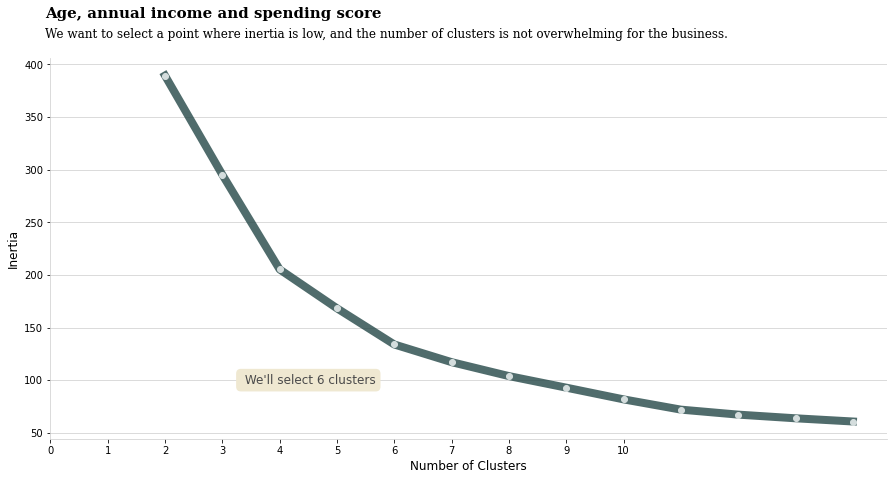

In [14]:
fig, ax = plt.subplots(figsize=(15,7))

clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(clusters_range,inertias, '-' , color='#244747',alpha = 0.8,linewidth=8)
plt.plot(clusters_range,inertias, 'o',linewidth=20,color='#d4dddd')    

##
plt.xlabel('Number of Clusters',fontsize=12) , plt.ylabel('Inertia',fontsize=12)
ax.xaxis.set_ticks(np.arange(0,11,1))

# Title & Subtitle
fig.text(0.12,0.96,'Age, annual income and spending score', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.12,0.92,'We want to select a point where inertia is low, and the number of clusters is not overwhelming for the business.',fontfamily='serif',fontsize=12)


ax.annotate(" We'll select 6 clusters", 
            xy=(4.5, 100), fontsize=12,
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

# Ax spines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
for s in ['left', 'bottom']:
    ax.spines[s].set_color('lightgray')

# Grid
ax.set_axisbelow(True)# Ax spines

ax.yaxis.grid(color='lightgray', linestyle='-')
plt.show()

In [15]:
# Running various cluster numbers with various random seeds
clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For N_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

In [16]:
# Turn results in to a pivot table
result = pd.DataFrame(results, columns=["Number of clusters","Random seed","Silhouette_score"])
pivot_km = pd.pivot_table(result, index="Number of clusters", columns="Random seed",values="Silhouette_score")

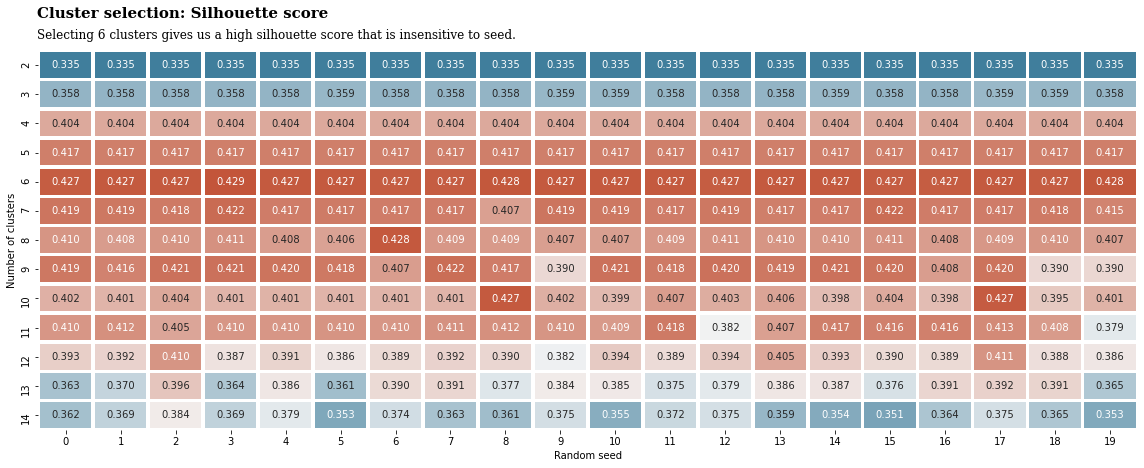

In [17]:
# Turn that pivot in to a nice visual
fig = plt.figure(figsize=(16, 6))

# Title and sub-title

fig.text(0.035, 1.05, 'Cluster selection: Silhouette score', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.035, 1.001, 'Selecting 6 clusters gives us a high silhouette score that is insensitive to seed.', fontsize=12, fontweight='light', fontfamily='serif')

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(pivot_km, annot=True, linewidths=2.5, fmt='.3f', cmap=cmap,cbar=False)

plt.tight_layout()

In [18]:
# Six looks to be a good number of clusters. We will also assign these clusters to a df
kmeans_sel = KMeans(n_clusters=6, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

For n_clusters = 6  and seed = 19 
The average silhouette_score is : 0.42742814991580175


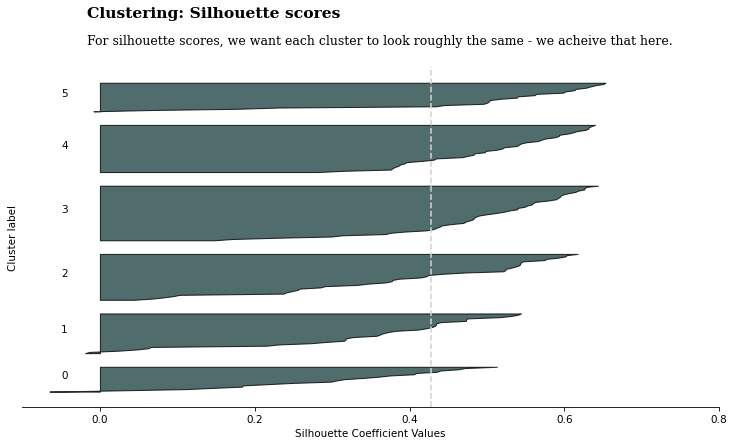

In [19]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=6, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 6," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax = plt.subplots(figsize=(12,6), dpi=75)

y_lower = 10
for i in range(6):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 6)
    ax.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor='#244747', edgecolor="black",linewidth=1, alpha=0.8)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
    
fig.text(0.198, .99, 'Clustering: Silhouette scores', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.198,.93, 'For silhouette scores, we want each cluster to look roughly the same - we acheive that here.', fontsize=12, fontweight='light', fontfamily='serif')
    
ax.get_yaxis().set_ticks([])
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax.axvline(x=silhouette_avg, color="lightgray", linestyle="--")
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
for s in ['top', 'right', 'left']:
    ax.spines[s].set_visible(False)
    
plt.show()

## **Silhouette score concepts:**

* Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are.
* Silhouette score takes into consideration the intra-cluster distance between the sample and other data points within the same cluster (a) and inter-cluster distance between the sample and the next nearest cluster (b).
* The silhouette score falls within the range [-1, 1].
* The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
* The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering.
* The aspects to look out for in Silhouette plots are cluster scores below the average silhouette score, wide fluctuations in the size of the clusters, and also the thickness of the silhouette plot.

In [20]:
clustered_data.head()

,Spending Score (1-100),Annual Income (k$),Age,Cluster
0,39,15,19,5
1,81,15,21,5
2,6,16,20,0
3,77,16,23,5
4,40,17,31,0


In [21]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km2 = clustered_data.groupby(['Cluster']).mean().round(1).reset_index()
grouped_km2['Cluster'] = grouped_km2['Cluster'].map(str)
grouped_km2

,Cluster,Spending Score (1-100),Annual Income (k$),Age
0,0,19.4,26.3,45.5
1,1,17.0,88.9,41.9
2,2,47.8,57.6,26.7
3,3,49.1,54.3,56.3
4,4,82.1,86.5,32.7
5,5,76.9,25.8,25.2


## **Conceptually showing clusters**

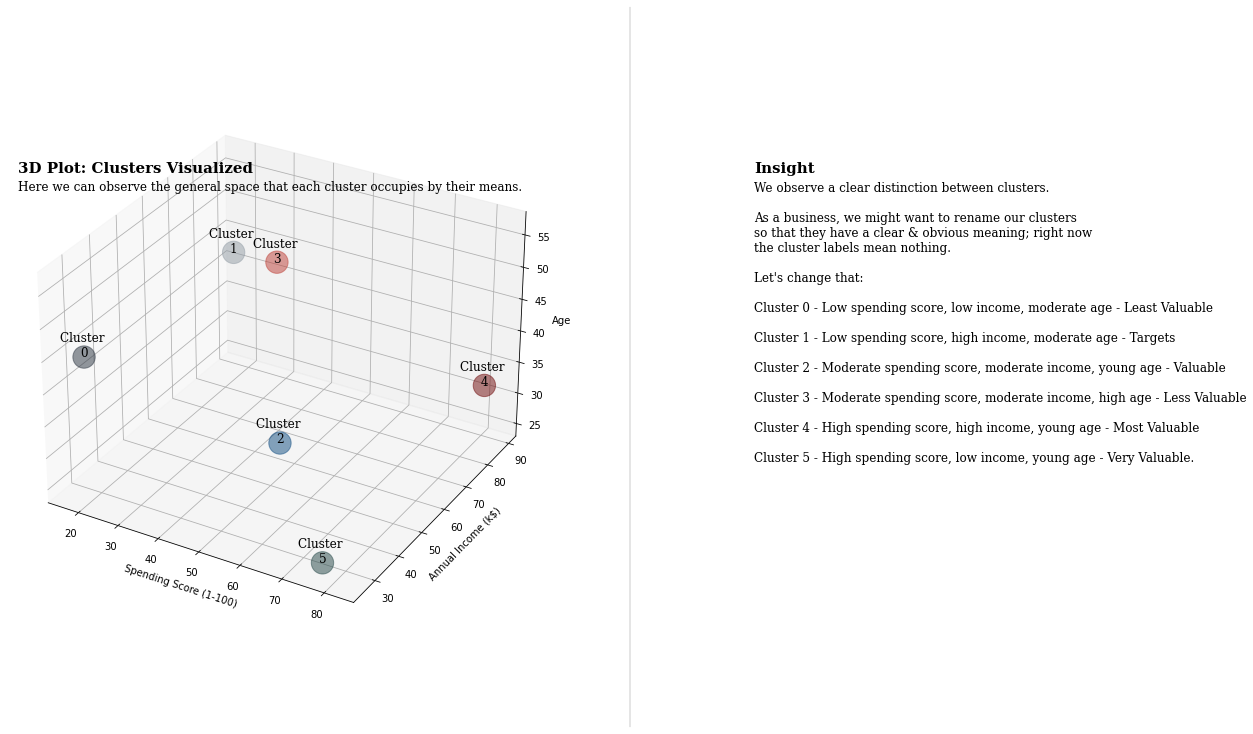

In [22]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_km2["Spending Score (1-100)"], grouped_km2["Annual Income (k$)"], grouped_km2["Age"],color=['#2a333f','#939da6','#0f4c81','#be3e35','#70090a','#244747'],alpha=0.5,s=500)

# add annotations one by one with a loop
for line in range(0,grouped_km.shape[0]):
     ax.text(grouped_km2['Spending Score (1-100)'][line], grouped_km2['Annual Income (k$)'][line],grouped_km2['Age'][line], s=('Cluster \n'+grouped_km2['Cluster'][line]), horizontalalignment='center', fontsize=12, fontweight='light', fontfamily='serif')
        
ax.set_xlabel("Spending Score (1-100)")
ax.set_ylabel("Annual Income (k$)")
ax.set_zlabel("Age")

fig.text(0.15, .77, '3D Plot: Clusters Visualized', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.15, .745, 'Here we can observe the general space that each cluster occupies by their means.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.172, 0.77, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.172, 0.347, '''
We observe a clear distinction between clusters. 

As a business, we might want to rename our clusters
so that they have a clear & obvious meaning; right now
the cluster labels mean nothing. 

Let's change that:

Cluster 0 - Low spending score, low income, moderate age - Least Valuable

Cluster 1 - Low spending score, high income, moderate age - Targets

Cluster 2 - Moderate spending score, moderate income, young age - Valuable

Cluster 3 - Moderate spending score, moderate income, high age - Less Valuable

Cluster 4 - High spending score, high income, young age - Most Valuable

Cluster 5 - High spending score, low income, young age - Very Valuable.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


**Now we have our clusters, we can explore how the average customer varies within each of them**

In [23]:
cluster_only = clustered_data[['Cluster']]

In [24]:
merge = pd.merge(df, cluster_only, left_index=True, right_index=True)
merge.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Age Range,Gender 1/0,age_band,Cluster
0,1,Male,19,15,39,Young,1,10 ~ 20,5
1,2,Male,21,15,81,Young,1,20 ~ 30,5
2,3,Female,20,16,6,Young,0,20 ~ 30,0
3,4,Female,23,16,77,Adult,0,20 ~ 30,5
4,5,Female,31,17,40,Adult,0,30 ~ 40,0


We can give our clusters meanigful names which will help business leaders to understand their importance.

What has more impact: 'We need to advertise to Cluster X' or 'We need to advertise to our High Value Cluster'

This is how we need to communicate our clusters

In [25]:
# Giving our clusters meaningful names

merge['Cluster_Label'] = merge['Cluster'].apply(lambda x: 'Least Valuable' if x == 0 else 
                                               'Targets' if x == 1 else
                                               'Valuable' if x == 2 else
                                               'Less Valuable' if x == 3 else
                                               'Most Valuable' if x == 4 else 'Very Valuable')

# New column for radar plots a bit later on 

merge['Sex (100=Male)'] = merge['Gender'].apply(lambda x: 100 if x == 'Male' else 0)


In [26]:
merge['Cluster'] = merge['Cluster'].map(str)
# Order for plotting categorical vars
Cluster_ord = ['0','1','2','3','4','5']
clus_label_order = ['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable']

In [27]:
clus_ord = merge['Cluster_Label'].value_counts().index

clu_data = merge['Cluster_Label'].value_counts()[clus_label_order]
##

data_cg = merge.groupby('Cluster_Label')['Gender'].value_counts().unstack().loc[clus_label_order]
data_cg['sum'] = data_cg.sum(axis=1)

##
data_cg_ratio = (data_cg.T / data_cg['sum']).T[['Male', 'Female']][::-1]


## **Exploring our Clusters**

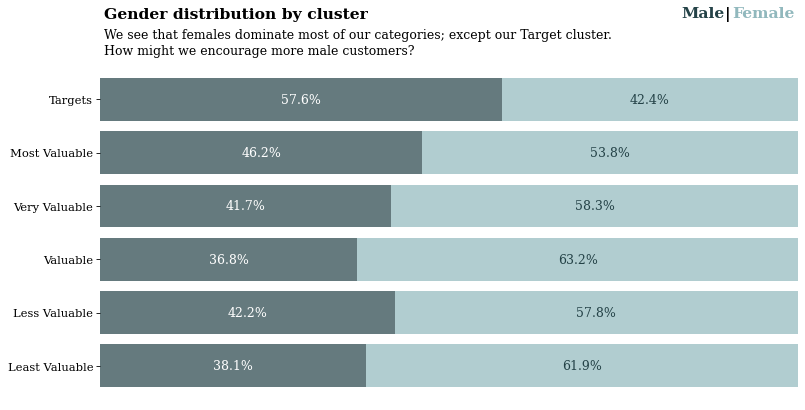

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax.barh(data_cg_ratio.index, data_cg_ratio['Male'], 
        color='#244247', alpha=0.7, label='Male')
ax.barh(data_cg_ratio.index, data_cg_ratio['Female'], left=data_cg_ratio['Male'], 
        color='#91b8bd', alpha=0.7, label='Female')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels((data_cg_ratio.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]+data_cg_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='#244247')
    

fig.text(0.129, 0.98, 'Gender distribution by cluster', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.129, 0.9, 
         '''
We see that females dominate most of our categories; except our Target cluster.
How might we encourage more male customers?''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.legend().set_visible(False)

fig.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')
plt.show()

**Insight**

let's focus on an important part of the plot.

Our 'Targets' group, that is, high income customers but low spending scores, are primarily male. How could we exploit this?

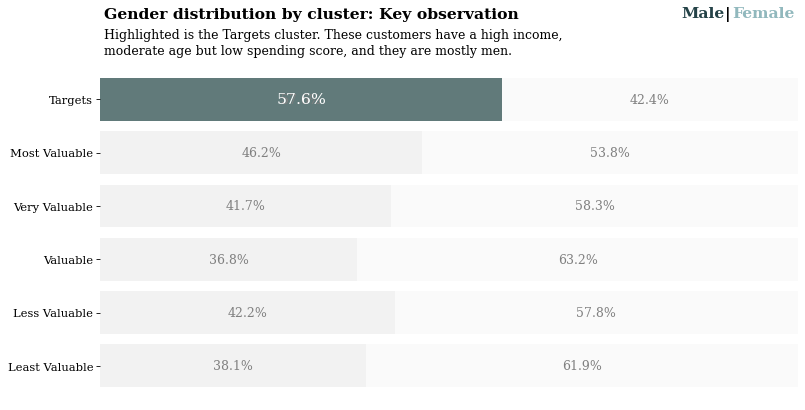

In [29]:
fig, ax = plt.subplots(1,1,figsize=(12, 6), dpi=75)

ax.barh(data_cg_ratio.index, data_cg_ratio['Male'], 
        color='gray', alpha=0.1, label='Male')
ax.barh(data_cg_ratio.index, data_cg_ratio['Female'], left=data_cg_ratio['Male'], 
        color='lightgray', alpha=0.1, label='Female')

ax.barh(5, data_cg_ratio['Male']['Targets'], 
        color='#244747', alpha=0.7, label='Male')


ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels((data_cg_ratio.index), fontfamily='serif', fontsize=11)


# male percentage
for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Male'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='gray')
    
ax.annotate(f"{data_cg_ratio['Male']['Targets']*100:.3}%", 
                   xy=(data_cg_ratio['Male']['Targets']/2, 'Targets'),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')  


for i in data_cg_ratio.index:
    ax.annotate(f"{data_cg_ratio['Female'][i]*100:.3}%", 
                   xy=(data_cg_ratio['Male'][i]+data_cg_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='gray')
    

fig.text(0.129, 0.98, 'Gender distribution by cluster: Key observation', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.129, 0.9, 
         '''
Highlighted is the Targets cluster. These customers have a high income, 
moderate age but low spending score, and they are mostly men. ''' , fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.legend().set_visible(False)

fig.text(0.77,0.98,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.819,0.98,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.827,0.98,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')
plt.show()

## **Box Plots**

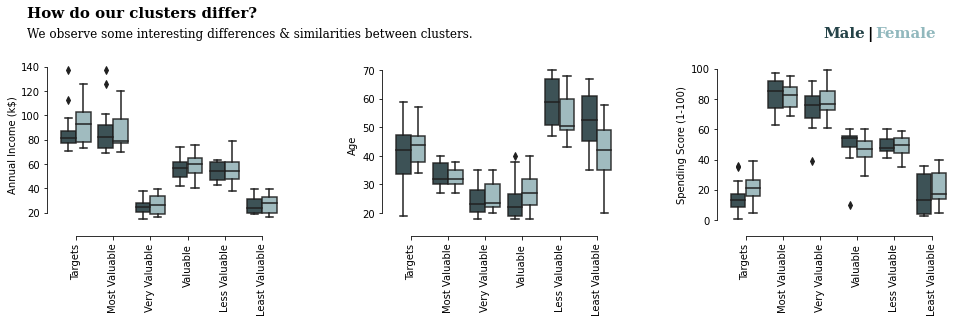

In [30]:
import matplotlib.gridspec as gridspec

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(16, 3))

# Title and sub-title

fig.text(0.099, 1.09, 'How do our clusters differ?', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.099, 1, 'We observe some interesting differences & similarities between clusters.', fontsize=12, fontweight='light', fontfamily='serif')

# Grid spec layout

ax1 = fig.add_subplot(gs[0, 0]) # row 0, col 0
ax1 = sns.boxplot(x='Cluster_Label',y='Annual Income (k$)',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax1.legend_.remove() 
ax1.set_xlabel('')

ax2 = fig.add_subplot(gs[0, 1]) # row 0, col 1
ax2 = sns.boxplot(x='Cluster_Label',y='Age',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax2.legend_.remove() 
ax2.set_xlabel('')

ax3 = fig.add_subplot(gs[0, 2]) # row 1, span all columns
ax3 = sns.boxplot(x='Cluster_Label',y='Spending Score (1-100)',hue='Gender',data=merge,order=['Targets','Most Valuable','Very Valuable','Valuable','Less Valuable','Least Valuable'],palette=['#244247','#91b8bd'],boxprops=dict(alpha=.9))
ax3.legend_.remove() 
ax3.set_xlabel('')

sns.despine(right=True)
sns.despine(offset=10, trim=True)

ax.legend().set_visible(False)
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)



fig.text(0.79,1,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.828,1,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.835,1,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None) # useful for adjusting space between subplots

## **Other ways to visualize differences...**

Clusters 2 & 3 (Valuable and Less Valuable) look similar in some respects, let's focus on those two for a moment

## **Radar Plots**

In [31]:
# Radar Plots
clustered_data = merge


clus0 = clustered_data[clustered_data['Cluster_Label'] == 'Least Valuable']
clus1 = clustered_data[clustered_data['Cluster_Label'] == 'Targets']
clus2 = clustered_data[clustered_data['Cluster_Label'] == 'Valuable']
clus3 = clustered_data[clustered_data['Cluster_Label'] == 'Less Valuable']
clus4 = clustered_data[clustered_data['Cluster_Label'] == 'Most Valuable']
clus5 = clustered_data[clustered_data['Cluster_Label'] == 'Very Valuable']

labels=np.array(['Age', 'Annual Income (k$)', 'Spending Score (1-100)','Sex (100=Male)'])
stats0=clus0.loc[:,labels].mean()
stats1=clus1.loc[:,labels].mean()
stats2=clus2.loc[:,labels].mean()
stats3=clus3.loc[:,labels].mean()
stats4=clus4.loc[:,labels].mean()
stats5=clus5.loc[:,labels].mean()


angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
stats0=np.concatenate((stats0,[stats0[0]]))
stats1=np.concatenate((stats1,[stats1[0]]))
stats2=np.concatenate((stats2,[stats2[0]]))
stats3=np.concatenate((stats3,[stats3[0]]))
stats4=np.concatenate((stats4,[stats4[0]]))
stats5=np.concatenate((stats5,[stats5[0]]))


angles=np.concatenate((angles,[angles[0]]))

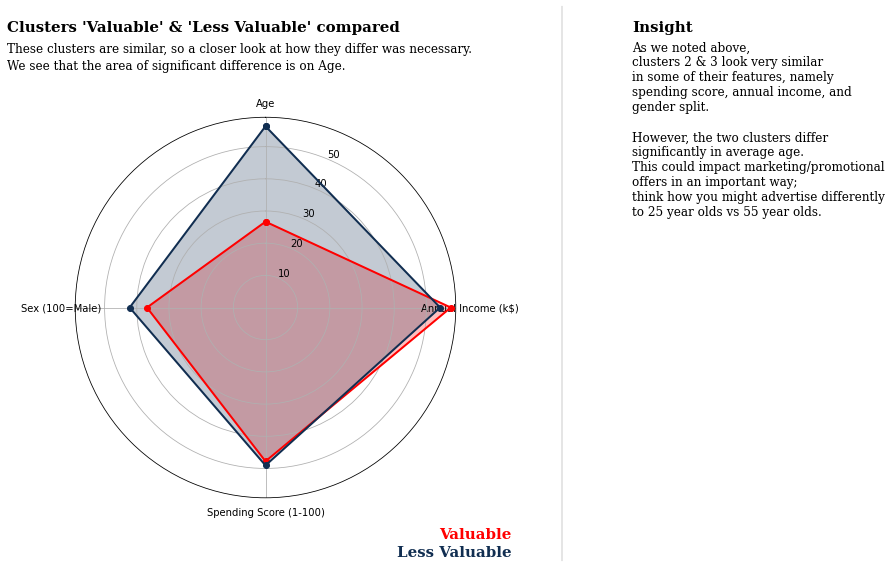

In [32]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax = plt.subplot(111, polar=True)

ax.plot(angles, stats2, 'o-', linewidth=2, color='#ff0000', label="Cluster 2: Valuable")
ax.fill(angles, stats2, color='#ff0000',alpha=0.25)

ax.plot(angles, stats3, 'o-', linewidth=2,color='#112e51',label="Cluster 3: Less Valuable")
ax.fill(angles, stats3, color='#112e51',alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids((angles * 180/np.pi)[0:4],labels) # Chnage this to match label count


fig.text(0, 1.05, "Clusters 'Valuable' & 'Less Valuable' compared", fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0,1.01, 'These clusters are similar, so a closer look at how they differ was necessary.', fontsize=12, fontweight='light', fontfamily='serif')
fig.text(0,0.975, 'We see that the area of significant difference is on Age.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.24, 1.05, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.24, 0.655, '''
As we noted above, 
clusters 2 & 3 look very similar 
in some of their features, namely
spending score, annual income, and
gender split.

However, the two clusters differ 
significantly in average age. 
This could impact marketing/promotional
offers in an important way;
think how you might advertise differently
to 25 year olds vs 55 year olds.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

fig.text(1,0.045,"Valuable", fontweight="bold", fontfamily='serif', ha='right',fontsize=15, color='#ff0000')
fig.text(1,0.01,"Less Valuable", fontweight="bold", fontfamily='serif',ha='right', fontsize=15, color='#112e51')

ax.grid(True)

All at once...

In [33]:
df = clustered_data[['Cluster_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)']]

df = df.groupby('Cluster_Label')['Cluster_Label','Age','Annual Income (k$)','Spending Score (1-100)','Sex (100=Male)'].mean().reset_index()


In [34]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
 
# Set data

# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
 
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,3,row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)
    #ax.set_xticks([]) # turn labels off if you want - can look quite nice

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([10,20,30,40,50,75,100], ["10","20","30","40","50","75","100"], color="grey", size=4)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('Cluster_Label').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()


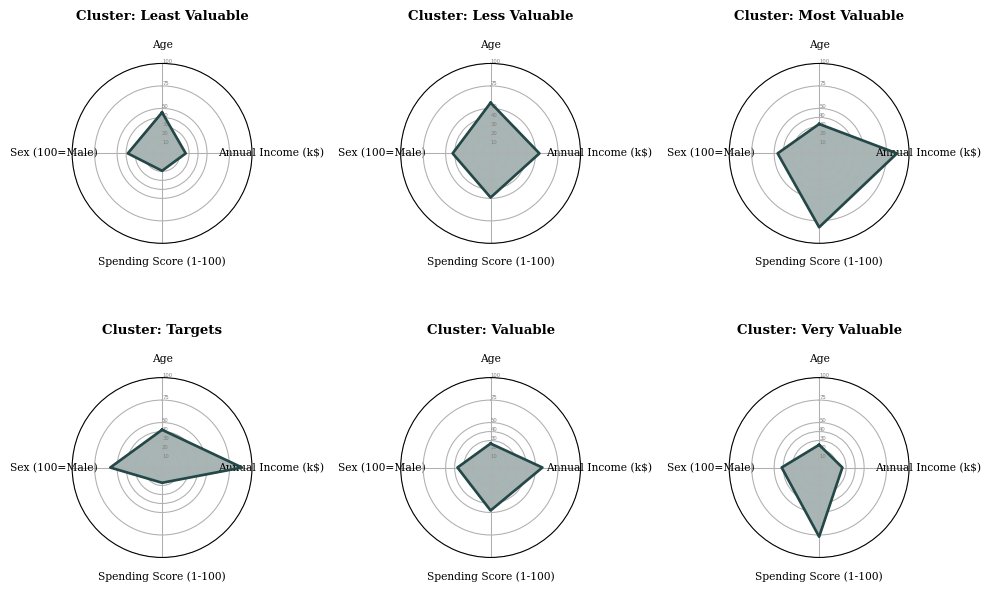

In [35]:

my_dpi=96

plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
 
# Create a color palette:
my_palette = plt.cm.get_cmap("crest", len(df.index))
 
# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='Cluster: '+df['Cluster_Label'][row], color='#244747') #change this to my_palette if you want colour to vary by cluster
    

## **Let's compare and contrast the most & least valuable clusters**

what do we observe?

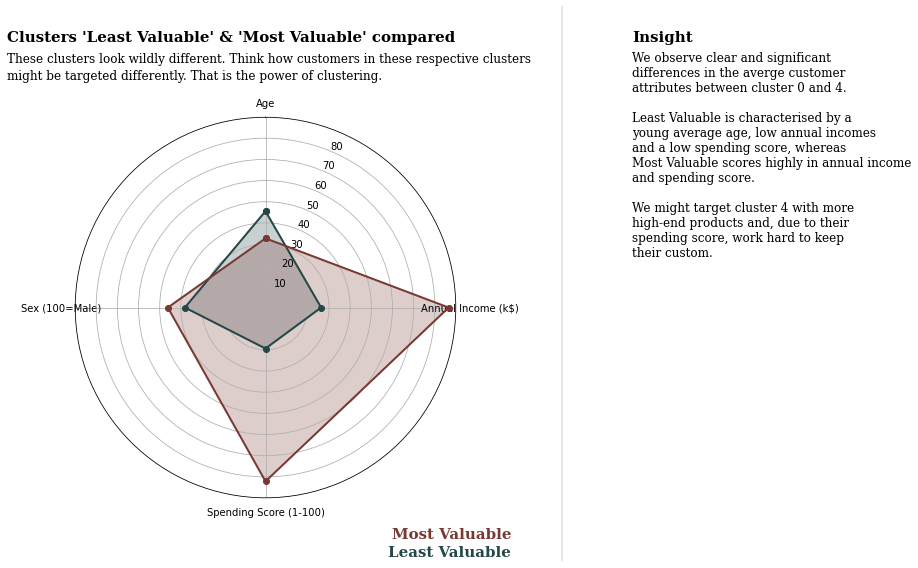

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax = plt.subplot(111, polar=True)

ax.plot(angles, stats0, 'o-', linewidth=2, color='#244747', label="Cluster 0")
ax.fill(angles, stats0, color='#244747',alpha=0.25)

ax.plot(angles, stats4, 'o-', linewidth=2,color='#7A3832',label="Cluster 4")
ax.fill(angles, stats4, color='#7A3832',alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids((angles * 180/np.pi)[0:4],labels)


fig.text(0, 1.03, "Clusters 'Least Valuable' & 'Most Valuable' compared", fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0,0.99, 'These clusters look wildly different. Think how customers in these respective clusters', fontsize=12, fontweight='light', fontfamily='serif')
fig.text(0,0.955, 'might be targeted differently. That is the power of clustering.', fontsize=12, fontweight='light', fontfamily='serif')


fig.text(1.24, 1.03, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.24, 0.574, '''
We observe clear and significant
differences in the averge customer
attributes between cluster 0 and 4.

Least Valuable is characterised by a
young average age, low annual incomes
and a low spending score, whereas
Most Valuable scores highly in annual income
and spending score.

We might target cluster 4 with more
high-end products and, due to their
spending score, work hard to keep 
their custom.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


# Add legend
#plt.legend(loc='upper right',frameon=False, bbox_to_anchor=(1.15, 0.1))
fig.text(1,0.045,"Most Valuable", fontweight="bold", fontfamily='serif', ha='right',fontsize=15, color='#7A3832')
fig.text(1,0.01,"Least Valuable", fontweight="bold", fontfamily='serif',ha='right', fontsize=15, color='#244747')


ax.grid(True)

## **Heatmaps**

In [37]:
df_hm = df.set_index('Cluster_Label')
df_hm = df_hm.reindex(['Targets',
 'Most Valuable',
 'Very Valuable',
 'Valuable',
 'Less Valuable',
 'Least Valuable'])


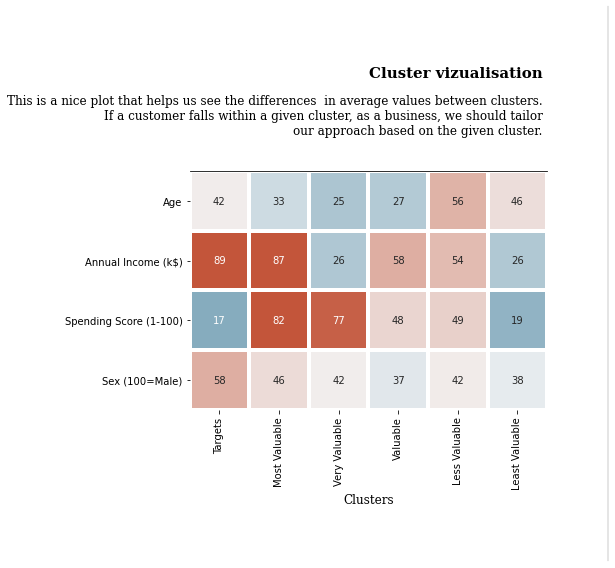

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_hm.T, 
            square=True,
            linewidth=3, 
            vmax=80, vmin=1, 
            cmap=cmap, 
            cbar=False, 
            ax=ax,annot=True)

ax.spines['top'].set_visible(True)

fig.text(0.97, 0.96, 'Cluster vizualisation', fontweight='bold', fontfamily='serif', fontsize=15, ha='right')    

fig.text(0.97, 0.955, '''
This is a nice plot that helps us see the differences  in average values between clusters.
If a customer falls within a given cluster, as a business, we should tailor
our approach based on the given cluster.
''', 
         fontweight='light', fontfamily='serif', fontsize=12, va='top', ha='right') 

import matplotlib.lines as lines
l1 = lines.Line2D([1.1, 1.1], [0, 1.1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

plt.xlabel("Clusters", fontsize=12, fontweight='light', fontfamily='serif')



plt.tight_layout()
plt.show()

## **Categorical Plots**

In [39]:
data = merge[['Gender','age_band','Cluster_Label']]


# Adding a single female to the age range 70-80 for the purposes of this visualization, not reccomended in the real world!

data.loc[-1] = ['Female', '70 ~ 80', 'Less Valuable']  # adding a row
data.index = data.index + 1  # shifting index
data = data.sort_index()  # sorting by index
data['count']=1

In [40]:
age_range_order = ['10 ~ 20', '20 ~ 30', '30 ~ 40','40 ~ 50','50 ~ 60','60 ~ 70','70 ~ 80'] #q15

  
clus_label_order = ['Targets',
 'Most Valuable',
 'Very Valuable',
 'Valuable',
 'Less Valuable',
 'Least Valuable'] 
 
data['count'] = 1


data_ca = pd.pivot_table(data, values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()
data_ca_man = pd.pivot_table(data[data['Gender']=='Male'], values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()
data_ca_woman = pd.pivot_table(data[data['Gender']=='Female'], values='count', index=['Cluster_Label'], columns=['age_band'], aggfunc=np.sum).fillna(0).astype(int).loc[clus_label_order, age_range_order].stack()


In [41]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9)

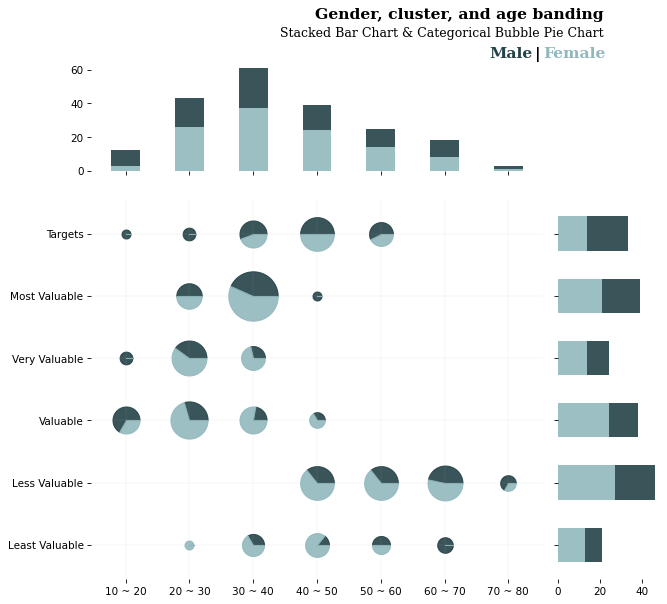

In [42]:
fig = plt.figure(figsize=(9, 9), dpi=75)

gs = fig.add_gridspec(5, 5)

# Pie charts

ax_plot = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in clus_label_order[::-1]:
    for age_idx in age_range_order:
        man = data_ca_man[cl_idx][age_idx]
        woman = data_ca_woman[cl_idx][age_idx]
        tot = data_ca[cl_idx][age_idx]
        drawPieMarker([age_idx],[cl_idx], [man/(man+woman), woman/(man+woman)] ,[tot*75], ['#244247', '#91b8bd'], ax=ax_plot)

ax_plot.grid(linewidth=0.1)        



 # Top
ax_pos = fig.add_subplot(gs[0, :4], sharex=ax_plot) 
data_age_woman = data[data['Gender']=='Female']['age_band'].value_counts()[age_range_order]
ax_pos.bar(data_age_woman.index, data_age_woman, width=0.45, alpha=0.9, color='#91b8bd')

data_age_man = data[data['Gender']=='Male']['age_band'].value_counts()[age_range_order]
ax_pos.bar(data_age_man.index, data_age_man, bottom=data_age_woman , width=0.45, alpha=0.9, color='#244247')

plt.setp(ax_pos.get_xticklabels(), visible=False)


# Side 
ax_exp = fig.add_subplot(gs[1:4, 4], sharey=ax_plot) 

data_cl_woman = data[data['Gender']=='Female']['Cluster_Label'].value_counts()[clus_label_order]
ax_exp.barh(data_cl_woman.index[::-1], data_cl_woman[::-1], height=0.55, alpha=0.9, color='#91b8bd')

data_cl_man = data[data['Gender']=='Male']['Cluster_Label'].value_counts()[clus_label_order]
ax_exp.barh(data_cl_man.index[::-1], data_cl_man[::-1], left= data_cl_woman[::-1],height=0.55, alpha=0.9, color='#244247')

plt.setp(ax_exp.get_yticklabels(), visible=False)


# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_plot.spines[s].set_visible(False)
    ax_pos.spines[s].set_visible(False)
    ax_exp.spines[s].set_visible(False)
ax.set_axisbelow(True)    

fig.text(0.9, 1.05, 'Gender, cluster, and age banding', fontweight='bold', fontfamily='serif', fontsize=15, ha='right') 
fig.text(0.9, 1.023, 'Stacked Bar Chart & Categorical Bubble Pie Chart', fontweight='light', fontfamily='serif', fontsize=12, ha='right')

fig.text(0.73,0.992,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#244247')
fig.text(0.798,0.992,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.81,0.992,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#91b8bd')

plt.tight_layout()
plt.show()

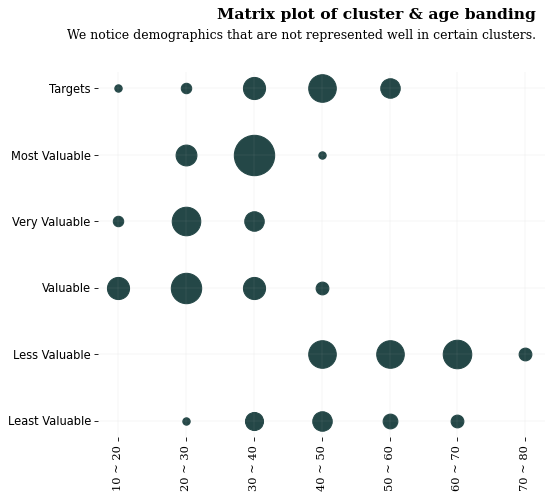

In [43]:

fig = plt.figure(figsize=(9, 9), dpi=75)

gs = fig.add_gridspec(5, 5)

fig.text(0.8, 0.85, 'Matrix plot of cluster & age banding', fontweight='bold', fontfamily='serif', fontsize=15, ha='right') 
fig.text(0.8, 0.82, 'We notice demographics that are not represented well in certain clusters.', fontweight='light', fontfamily='serif', fontsize=12, ha='right')



# Pie charts  / Matrix plot

ax_plot = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in clus_label_order[::-1]:
    for age_idx in age_range_order:
        
        tot = data_ca[cl_idx][age_idx]
        ax_plot.scatter(age_idx, cl_idx, s=tot*50, color='#244747')    

ax_plot.grid(linewidth=0.1)        
ax_plot.set_xticklabels(age_range_order,fontfamily='serif', fontsize=11, rotation=90)
plt.yticks(fontsize=11)


# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_plot.spines[s].set_visible(False)
    ax_pos.spines[s].set_visible(False)
    ax_exp.spines[s].set_visible(False)
    
#sns.despine(offset=20, trim=True)
ax.set_axisbelow(True)   

plt.tight_layout()

# Thanks for reading!

I'll welcome all comments, I know there are probably much more efficient ways to do things, but that's the beauty of coding - we can always improve!

As I said above, this is my first notebook and was really inspired to give it a go due to a stunning few notebooks from Subin An with respect to data visualisation. I learned a lot. Check him out.

Next steps would be using vizualisations to make reccomendations for the business. Maybe in another notebook...